# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import timm
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import EfficientNet_b1 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

In [4]:
model = timm.create_model('efficientnet_b1', pretrained=True)
#3, 320, 320
#name: (channel_multiplier, depth_multiplier, resolution, dropout_rate)
#(1.4, 1.8, 380, 0.4)

In [5]:
model.blocks[6][1].act1

SiLU(inplace=True)

## load config and set logger

In [6]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [7]:
# Setting seed
modeler.set_seed(42)

In [8]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/config.yaml'

In [9]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [10]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3017, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9


## training

In [11]:
#############################################################################
# run
#############################################################################
def run_extract(machine_type, dev_paths):
    com.tic()
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type, mode='extract')
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(n_out=config['param']['mel_bins'])
    pretrained_dict = torch.load(f'{MODEL_DIR}/{machine_type}_model.pkl')
    net.load_state_dict(pretrained_dict.state_dict(), strict=True)
    #optimizer = optim.Adam(net.parameters(), lr=config['param']['lr'])
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [12]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

# run

In [13]:
for machine_type in machine_types:
    run_extract(machine_type, dev_paths)

2021-08-12 19:43:20,185 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-08-12 19:43:20,186 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-12 19:43:20,187 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:03<01:15,  3.26s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:05<01:03,  2.90s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:08<00:59,  2.84s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:11<00:56,  2.82s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:14<00:52,  2.76s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:16<00:50,  2.79s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:19<00:46,  2.74s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:22<00:43,  2.74s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:25<00:41,  2.77s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:27<00:38,  2.74s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:30<00:36,  2.77s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:33<00:32,  2.73s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:36<00:29,  2.72s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [00:38<00:27,  2.76s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [00:41<00:24,  2.74s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [00:44<00:22,  2.76s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [00:47<00:19,  2.76s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [00:49<00:16,  2.78s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [00:52<00:13,  2.77s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [00:55<00:11,  2.76s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [00:58<00:08,  2.73s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:00<00:05,  2.68s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:03<00:02,  2.64s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

torch.Size([88, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

torch.Size([88, 3, 128, 501])


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]
2021-08-12 19:44:35,583 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/fan_features.pkl
2021-08-12 19:44:35,585 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-08-12 19:44:35,586 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-12 19:44:35,587 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 76.428956270 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:03<01:12,  3.14s/it]


KeyboardInterrupt: 

In [14]:
machine_type = 'fan'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

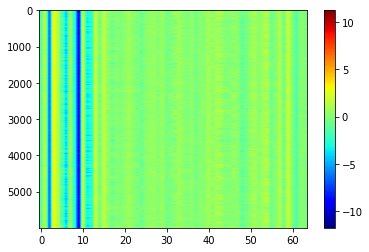

In [15]:
plt.imshow(ext_data['train']['features'][:,:64], cmap='jet', aspect='auto')
plt.colorbar()

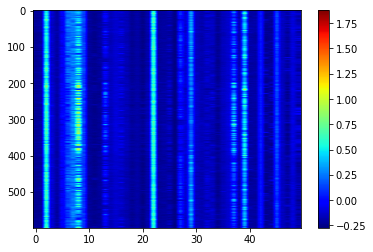

In [16]:
plt.imshow(ext_data['valid_source']['features'][:,2050:2100], cmap='jet', aspect='auto')
plt.colorbar()

In [17]:
ext_data['valid_source']['features'].shape

(600, 3024)